In [1]:
import os,math
import rasterio
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xarray as xr
import rioxarray as rxr
import geopandas as gpd
from glob import glob
from netCDF4 import Dataset
from functools import partial
from pyproj import CRS
from pyproj import Transformer
from shapely.geometry import Point, mapping
from shapely.ops import transform
from scipy.optimize import curve_fit
from sympy import symbols, solve

In [2]:
def drct2val(x):
    if x == 'E':
        return [337.5,22.5,157.5,202.5]
    if x == 'NE':
        return [22.5,67.5,202.5,247.5]
    if x == 'N':
        return [67.5,112.5,247.5,292.5]
    if x == 'NW':
        return [112.5,157.5,292.5,337.5]
    if x == 'W':
        return [157.5,202.5,337.5,22.5]
    if x == 'SW':
        return [202.5,247.5,22.5,67.5]
    if x == 'S':
        return [247.5,292.5,67.5,112.5]
    if x == 'SE':
        return [292.5,337.5,112.5,157.5]

In [3]:
wind_sum = pd.read_csv('/glade/scratch/USERNAME/MRMS_PrecipData/T2Drct_SumPrecip60.csv',sep=' ')
#ls_drct = wind_sum['Top 2 drct'].to_list()
#print(wind_sum)

In [7]:
start_yr = 2015
end_yr = 2021
ls_city = ['Atlanta','Austin','Charlotte','Cincinnati','Columbus','Dallas','Houston','Indianapolis','KC','Louisville',
           'Memphis','Miami','Minneapolis','Nashville','NYC','OKC','Omaha','Orlando','Phoenix','Pittsburgh',
           'Richmond','SanAntonio','StLouis','Tucson','Philadelphia','DC','Baltimore']

In [5]:
os.chdir('/glade/scratch/USERNAME/MRMS_PrecipData/')
res_wind = []
for city in ls_city:
    wind = pd.DataFrame()
    for year in range(start_yr,end_yr+1):
        tmp = pd.read_csv(str(year)+'/wind_drct_'+city+'.txt',sep=' ',header=None)
        wind = pd.concat([wind,tmp],ignore_index=True)
        
    wind.columns = ['time','direction','speed']
    wind['zone'] = pd.cut(x=wind['direction'],bins=[0]+list(np.arange(22.5,338,45))+[360],right=False,
      labels=['E','NE','N','NW','W','SW','S','SE','E'],ordered=False)
    
    drcts = wind_sum[wind_sum['City'] == city]['Top 2 drct'].values[0].split('+')
    wind = wind[wind['zone'].isin(drcts)]
    res_wind.append(wind['speed'].tolist())

Text(0.08, 0.5, 'Number of Hours')

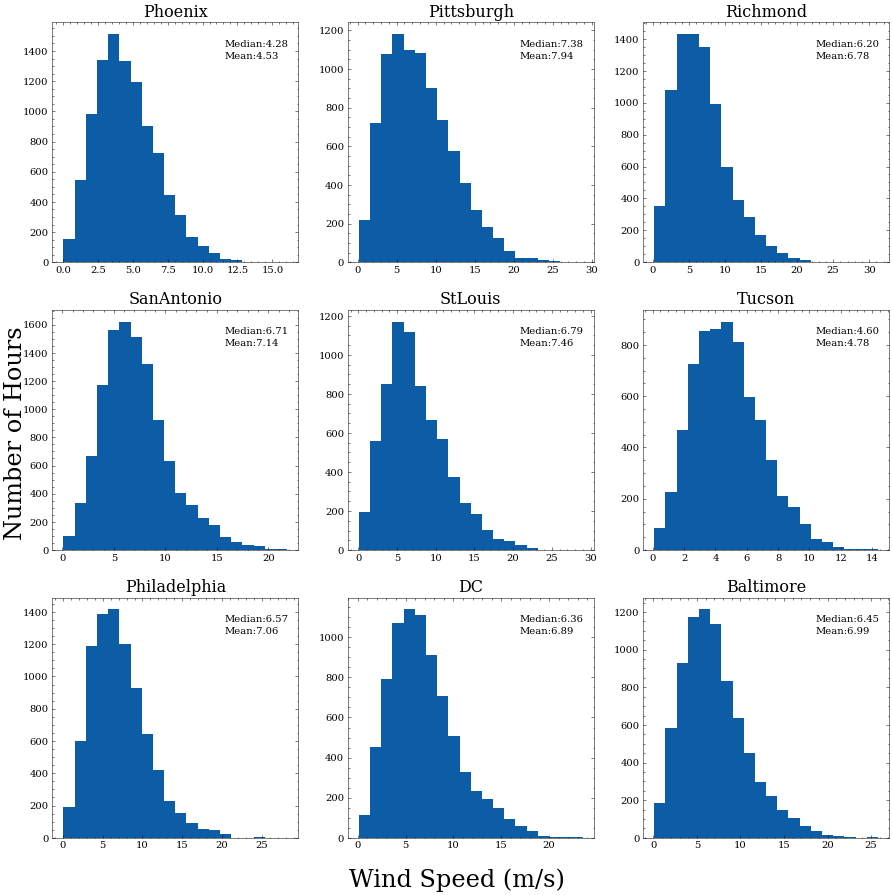

In [25]:
from statistics import median
from statistics import mean
plt.style.use(['science','no-latex'])

fig,ax = plt.subplots(3,3,figsize=(15,15))
for i,city in zip(range(18,27),ls_city[18:27]):
    ax[int(np.floor(i/3))%3,i%3].set_title(city,size=16)
    ax[int(np.floor(i/3))%3,i%3].hist(res_wind[i],bins=20)
    ax[int(np.floor(i/3))%3,i%3].text(0.7,0.9,'Median:%.2f'%median(res_wind[i]),transform=ax[int(np.floor(i/3))%3,i%3].transAxes)
    ax[int(np.floor(i/3))%3,i%3].text(0.7,0.85,'Mean:%.2f'%mean(res_wind[i]),transform=ax[int(np.floor(i/3))%3,i%3].transAxes)
    
fig.text(0.5,0.08,'Wind Speed (m/s)',size=24,ha='center')
fig.text(0.08,0.5,'Number of Hours',size=24,va='center',rotation='vertical')

## calculate descriptive features of the wind data

In [7]:
os.chdir('/glade/scratch/USERNAME/MRMS_PrecipData/')
wind_sum = pd.read_csv('/glade/scratch/USERNAME/MRMS_PrecipData/T2Drct_SumPrecip60.csv',sep=' ')
df_wind = pd.DataFrame()
tmp_q1 = []
tmp_q2 = []
tmp_q3 = []
tmp_mean = []
for city in ls_city:
    wind = pd.DataFrame()
    for year in range(start_yr,end_yr+1):
        tmp = pd.read_csv(str(year)+'/wind_drct_'+city+'.txt',sep=' ',header=None)
        wind = pd.concat([wind,tmp],ignore_index=True)
        
    wind.columns = ['time','direction','speed']
    wind['zone'] = pd.cut(x=wind['direction'],bins=[0]+list(np.arange(22.5,338,45))+[360],right=False,
      labels=['E','NE','N','NW','W','SW','S','SE','E'],ordered=False)
    drcts = wind_sum[wind_sum['City'] == city]['Top 2 drct'].values[0].split('+')
    wind = wind[wind['zone'].isin(drcts)]
    tmp_q1.append(wind['speed'].quantile(q=0.25))
    tmp_q2.append(wind['speed'].quantile(q=0.5))
    tmp_q3.append(wind['speed'].quantile(q=0.75))
    tmp_mean.append(wind['speed'].mean())

df_wind['City'] = ls_city
df_wind['Q1'] = tmp_q1
df_wind['Median'] = tmp_q2
df_wind['Q3'] = tmp_q3
df_wind['Mean'] = tmp_mean
    
print(df_wind)
#df_wind.to_csv('DmntWndStats.csv',sep = ' ')

            City      Q1  Median       Q3      Mean
0        Atlanta  3.1625   5.280   8.3875  6.059235
1         Austin  4.9100   7.010   9.4700  7.495620
2      Charlotte  3.2900   5.340   8.1400  6.004419
3     Cincinnati  4.2400   7.130  10.6700  7.772186
4       Columbus  4.7600   7.590  10.9025  8.110855
5         Dallas  4.6700   6.700   9.2375  7.198016
6        Houston  4.2500   6.560   9.0800  6.978701
7   Indianapolis  4.8100   7.800  11.2300  8.360018
8             KC  5.2900   8.260  11.4100  8.678794
9     Louisville  4.4900   7.280  10.6500  7.836579
10       Memphis  4.0500   6.575   9.5600  7.158512
11         Miami  3.2500   4.920   6.9850  5.275426
12   Minneapolis  5.3800   8.330  11.6200  8.786393
13     Nashville  3.8500   6.430   9.5250  7.094205
14           NYC  4.9100   6.980   9.4500  7.369431
15           OKC  5.5725   8.390  11.5300  8.798568
16         Omaha  5.4300   8.470  12.1900  9.046901
17       Orlando  3.1000   5.070   7.5150  5.636731
18       Pho

## DEI at conditional wind speed

### Low wind speed (<Q1)

In [13]:
os.chdir('/glade/scratch/USERNAME/MRMS_PrecipData/Precip_map/')

ls_city = ['Atlanta','Austin','Charlotte','Cincinnati','Columbus','Dallas','Houston','Indianapolis','KC','Louisville',
           'Memphis','Miami','Minneapolis','Nashville','NYC','OKC','Omaha','Orlando','Phoenix','Pittsburgh',
           'Richmond','SanAntonio','StLouis','Tucson','Philadelphia','DC','Baltimore']

## read csv containing prevailing directions
dat_drct = pd.read_csv('../T2Drct_SumPrecip60.csv',sep = ' ')

ls_up = [] ## store mean annual precip at upwind region
ls_dn = []
for city in ls_city:
    ras_domain = rxr.open_rasterio('Wnd_Quantile/'+city+'_Precip60Q1.tif')
    ras_domain = ras_domain[0]
    
    # first 2 directions
    drcts = dat_drct[dat_drct['City']==city]['Top 2 drct'].values[0]
    d1 = drcts.split('+')[0]
    d2 = drcts.split('+')[1]
    
    # angle array
    center_x = int(np.floor(ras_domain.x.size/2))
    center_y = int(np.floor(ras_domain.y.size/2))
    xmat = np.array([[x-ras_domain.x[center_x].values for x in ras_domain.x.values]]*len(ras_domain.y.values))
    ymat = np.array([[y-ras_domain.y[center_y].values for y in ras_domain.y.values]]*len(ras_domain.x.values)).T
    arr_ang = np.rad2deg(np.arctan2(ymat,xmat))
    arr_ang = np.array(arr_ang<0)*360+arr_ang
    
    ang_buffer = xr.DataArray(
             data = arr_ang,
             dims = ['y','x'], # control the x,y layout when plotting
             coords = dict(
               x = (['x'],ras_domain.x.values),
               y = (['y'],ras_domain.y.values),
               )
            )
    
    if d1 == 'E':
        ras_up1 = ras_domain.where((ang_buffer>=drct2val(d1)[0])|(ang_buffer<=drct2val(d1)[1]))
        ras_dn1 = ras_domain.where((ang_buffer>=drct2val(d1)[2])&(ang_buffer<=drct2val(d1)[3]))
    elif d1 == 'W':
        ras_up1 = ras_domain.where((ang_buffer>=drct2val(d1)[0])&(ang_buffer<=drct2val(d1)[1]))
        ras_dn1 = ras_domain.where((ang_buffer>=drct2val(d1)[2])|(ang_buffer<=drct2val(d1)[3]))
    else:
        ras_up1 = ras_domain.where((ang_buffer>=drct2val(d1)[0])&(ang_buffer<=drct2val(d1)[1]))
        ras_dn1 = ras_domain.where((ang_buffer>=drct2val(d1)[2])&(ang_buffer<=drct2val(d1)[3]))
        
    if d2 == 'E':
        ras_up2 = ras_domain.where((ang_buffer>=drct2val(d2)[0])|(ang_buffer<=drct2val(d2)[1]))
        ras_dn2 = ras_domain.where((ang_buffer>=drct2val(d2)[2])&(ang_buffer<=drct2val(d2)[3]))
    elif d2 == 'W':
        ras_up2 = ras_domain.where((ang_buffer>=drct2val(d2)[0])&(ang_buffer<=drct2val(d2)[1]))
        ras_dn2 = ras_domain.where((ang_buffer>=drct2val(d2)[2])|(ang_buffer<=drct2val(d2)[3]))
    else:
        ras_up2 = ras_domain.where((ang_buffer>=drct2val(d2)[0])&(ang_buffer<=drct2val(d2)[1]))
        ras_dn2 = ras_domain.where((ang_buffer>=drct2val(d2)[2])&(ang_buffer<=drct2val(d2)[3]))
        
    # calculate average precip (sum in 7 years) at upwind and downwind regions of the 2 directions altogether
    res_up = (ras_up1.sum().values+ras_up2.sum().values)/(ras_up1.count().values+ras_up2.count().values)
    res_dn = (ras_dn1.sum().values+ras_dn2.sum().values)/(ras_dn1.count().values+ras_dn2.count().values)

    ls_up.append(res_up)
    ls_dn.append(res_dn)

print(ls_up)
print(ls_dn)

[572.9833831837819, 456.6028305621536, 602.5120530012772, 410.0989695478314, 441.0627226840855, 588.7815533980582, 913.6916369401506, 444.49803120356614, 626.3005656108597, 549.4493222427603, 400.4269349093264, 327.5798757170172, 291.94112903225806, 564.6044906378927, 264.4918614974845, 621.2807707055215, 865.8221260132646, 1767.7013590844062, 254.23419612794612, 432.97766272189347, 544.4108205449421, 718.1670872022607, 405.80820726172465, 610.6527345102112, 348.68388989169677, 378.22960283251234, 346.32943349753697]
[765.1054247697032, 444.82378400659525, 665.9046853856563, 480.82281848586194, 399.25323834196894, 628.5251636661211, 845.9327280231118, 546.2221371708512, 480.75992555831266, 588.3637362637363, 427.07186978297165, 1119.9413019287833, 320.70280241935484, 516.4629202373105, 213.19746966558154, 616.4806034482758, 496.6546141915471, 1472.1570155902004, 288.20790122407345, 384.88473053892216, 665.0843908629441, 523.2185973127035, 478.4749292675259, 592.2160419532324, 444.98470

In [14]:
## calculate DEI using results from above cell
DEI_lws = [(j-i)/(i+j)/2 for i,j in zip(ls_up,ls_dn)]
#DEI_lws = [round(x,2) for x in DEI_lws]
print(DEI_lws)

[0.07178971995130827, -0.006533558231578042, 0.024988881991969206, 0.039691390359933514, -0.02487724039602065, 0.016324402761825674, -0.01925379935235593, 0.051338465297519315, -0.0657329211969442, 0.017100530588063115, 0.01609968178960273, 0.27369597020350195, 0.02347340103324634, -0.02226575785945117, -0.0536901166570045, -0.0019390519681256565, -0.13547662904183708, -0.04561068869621324, 0.03131551299389655, -0.029401603851245003, 0.049885923143728125, -0.0785205163557721, 0.041087927047332974, -0.007663634187589648, 0.060668151683826624, 0.04537514991854763, 0.06830933032015134]


### High wind speed (>Q3)

In [15]:
os.chdir('/glade/scratch/USERNAME/MRMS_PrecipData/Precip_map/')

ls_city = ['Atlanta','Austin','Charlotte','Cincinnati','Columbus','Dallas','Houston','Indianapolis','KC','Louisville',
           'Memphis','Miami','Minneapolis','Nashville','NYC','OKC','Omaha','Orlando','Phoenix','Pittsburgh',
           'Richmond','SanAntonio','StLouis','Tucson','Philadelphia','DC','Baltimore']

## read csv containing prevailing directions
dat_drct = pd.read_csv('../T2Drct_SumPrecip60.csv',sep = ' ')

ls_up = [] ## store mean annual precip at upwind region
ls_dn = []
for city in ls_city:
    ras_domain = rxr.open_rasterio('Wnd_Quantile/'+city+'_Precip60Q3.tif')
    ras_domain = ras_domain[0]
    
    # first 2 directions
    drcts = dat_drct[dat_drct['City']==city]['Top 2 drct'].values[0]
    d1 = drcts.split('+')[0]
    d2 = drcts.split('+')[1]
    
    # angle array
    center_x = int(np.floor(ras_domain.x.size/2))
    center_y = int(np.floor(ras_domain.y.size/2))
    xmat = np.array([[x-ras_domain.x[center_x].values for x in ras_domain.x.values]]*len(ras_domain.y.values))
    ymat = np.array([[y-ras_domain.y[center_y].values for y in ras_domain.y.values]]*len(ras_domain.x.values)).T
    arr_ang = np.rad2deg(np.arctan2(ymat,xmat))
    arr_ang = np.array(arr_ang<0)*360+arr_ang
    
    ang_buffer = xr.DataArray(
             data = arr_ang,
             dims = ['y','x'], # control the x,y layout when plotting
             coords = dict(
               x = (['x'],ras_domain.x.values),
               y = (['y'],ras_domain.y.values),
               )
            )
    
    if d1 == 'E':
        ras_up1 = ras_domain.where((ang_buffer>=drct2val(d1)[0])|(ang_buffer<=drct2val(d1)[1]))
        ras_dn1 = ras_domain.where((ang_buffer>=drct2val(d1)[2])&(ang_buffer<=drct2val(d1)[3]))
    elif d1 == 'W':
        ras_up1 = ras_domain.where((ang_buffer>=drct2val(d1)[0])&(ang_buffer<=drct2val(d1)[1]))
        ras_dn1 = ras_domain.where((ang_buffer>=drct2val(d1)[2])|(ang_buffer<=drct2val(d1)[3]))
    else:
        ras_up1 = ras_domain.where((ang_buffer>=drct2val(d1)[0])&(ang_buffer<=drct2val(d1)[1]))
        ras_dn1 = ras_domain.where((ang_buffer>=drct2val(d1)[2])&(ang_buffer<=drct2val(d1)[3]))
        
    if d2 == 'E':
        ras_up2 = ras_domain.where((ang_buffer>=drct2val(d2)[0])|(ang_buffer<=drct2val(d2)[1]))
        ras_dn2 = ras_domain.where((ang_buffer>=drct2val(d2)[2])&(ang_buffer<=drct2val(d2)[3]))
    elif d2 == 'W':
        ras_up2 = ras_domain.where((ang_buffer>=drct2val(d2)[0])&(ang_buffer<=drct2val(d2)[1]))
        ras_dn2 = ras_domain.where((ang_buffer>=drct2val(d2)[2])|(ang_buffer<=drct2val(d2)[3]))
    else:
        ras_up2 = ras_domain.where((ang_buffer>=drct2val(d2)[0])&(ang_buffer<=drct2val(d2)[1]))
        ras_dn2 = ras_domain.where((ang_buffer>=drct2val(d2)[2])&(ang_buffer<=drct2val(d2)[3]))
        
    # calculate average precip (sum in 7 years) at upwind and downwind regions of the 2 directions altogether
    res_up = (ras_up1.sum().values+ras_up2.sum().values)/(ras_up1.count().values+ras_up2.count().values)
    res_dn = (ras_dn1.sum().values+ras_dn2.sum().values)/(ras_dn1.count().values+ras_dn2.count().values)

    ls_up.append(res_up)
    ls_dn.append(res_dn)

print(ls_up)
print(ls_dn)

[821.8486208042539, 445.0696753760887, 745.4244891443167, 1075.4977699169485, 847.4444774346794, 372.21936893203883, 1249.9269718588982, 931.4093610698366, 907.8190799396682, 1245.9008780036968, 872.901149611399, 941.5155831739962, 919.2087903225806, 974.4824658838464, 1465.7049422906184, 402.91391871165644, 589.878822770818, 1032.761444921316, 89.39554924242424, 912.6340976331361, 920.3491230817413, 317.64902099313684, 928.6141452344932, 245.1070439598477, 1456.0815282791816, 1063.855834359606, 1202.5668103448277]
[778.7367792562266, 346.6238149216818, 804.6811569688768, 1020.5589844937671, 925.8249009448339, 570.4883899345335, 1445.0900742880726, 850.1377832210655, 1157.7582196029778, 1072.098273155416, 1029.4086811352254, 1142.3944732937684, 902.5004032258065, 1050.0886618325642, 1199.1438295353655, 371.6070819967923, 702.4296238852269, 865.8773199703044, 125.23634605576335, 958.5488023952096, 1000.4289340101523, 263.3544126628664, 1171.5268783401445, 314.5488952888583, 1247.9253149

In [16]:
DEI_hws = [(j-i)/(i+j)/2 for i,j in zip(ls_up,ls_dn)]
#DEI_hws = [round(x,2) for x in DEI_hws]
print(DEI_hws)

[-0.01346752305325235, -0.06217422630150691, 0.019113751366928788, -0.013105271435893661, 0.022100540523003274, 0.10515932384012393, 0.036208138777488706, -0.02280926949062553, 0.060501037583693996, -0.037489790443057516, 0.041136183232149896, 0.0481975912291202, -0.004585909528246095, 0.01867215108268308, -0.050014303921006795, -0.02021045051472328, 0.04354641548836245, -0.04394836133047613, 0.08349364096968341, 0.012268898128926346, 0.020845669970234317, -0.04672486011710631, 0.05783248133789391, 0.06203976984701605, -0.03849032665438527, 0.045571307457402434, 0.005845227353490796]


## Mid-speed wind (Q1 - Q2)

In [17]:
os.chdir('/glade/scratch/USERNAME/MRMS_PrecipData/Precip_map/')

ls_city = ['Atlanta','Austin','Charlotte','Cincinnati','Columbus','Dallas','Houston','Indianapolis','KC','Louisville',
           'Memphis','Miami','Minneapolis','Nashville','NYC','OKC','Omaha','Orlando','Phoenix','Pittsburgh',
           'Richmond','SanAntonio','StLouis','Tucson','Philadelphia','DC','Baltimore']

## read csv containing prevailing directions
dat_drct = pd.read_csv('../T2Drct_SumPrecip60.csv',sep = ' ')

ls_up = [] ## store mean annual precip at upwind region
ls_dn = []
for city in ls_city:
    
    ras_m1ws = rxr.open_rasterio('Wnd_Quantile/'+city+'_Precip60Q1_Q2.tif')
    ras_m1ws = ras_m1ws[0]
    
    # first 2 directions
    drcts = dat_drct[dat_drct['City']==city]['Top 2 drct'].values[0]
    d1 = drcts.split('+')[0]
    d2 = drcts.split('+')[1]
    
    # angle array
    center_x = int(np.floor(ras_m1ws.x.size/2))
    center_y = int(np.floor(ras_m1ws.y.size/2))
    xmat = np.array([[x-ras_m1ws.x[center_x].values for x in ras_m1ws.x.values]]*len(ras_m1ws.y.values))
    ymat = np.array([[y-ras_m1ws.y[center_y].values for y in ras_m1ws.y.values]]*len(ras_m1ws.x.values)).T
    arr_ang = np.rad2deg(np.arctan2(ymat,xmat))
    arr_ang = np.array(arr_ang<0)*360+arr_ang
    
    ang_buffer = xr.DataArray(
             data = arr_ang,
             dims = ['y','x'], # control the x,y layout when plotting
             coords = dict(
               x = (['x'],ras_m1ws.x.values),
               y = (['y'],ras_m1ws.y.values),
               )
            )
    
    if d1 == 'E':
        ras_up1 = ras_m1ws.where((ang_buffer>=drct2val(d1)[0])|(ang_buffer<=drct2val(d1)[1]))
        ras_dn1 = ras_m1ws.where((ang_buffer>=drct2val(d1)[2])&(ang_buffer<=drct2val(d1)[3]))
    elif d1 == 'W':
        ras_up1 = ras_m1ws.where((ang_buffer>=drct2val(d1)[0])&(ang_buffer<=drct2val(d1)[1]))
        ras_dn1 = ras_m1ws.where((ang_buffer>=drct2val(d1)[2])|(ang_buffer<=drct2val(d1)[3]))
    else:
        ras_up1 = ras_m1ws.where((ang_buffer>=drct2val(d1)[0])&(ang_buffer<=drct2val(d1)[1]))
        ras_dn1 = ras_m1ws.where((ang_buffer>=drct2val(d1)[2])&(ang_buffer<=drct2val(d1)[3]))
        
    if d2 == 'E':
        ras_up2 = ras_m1ws.where((ang_buffer>=drct2val(d2)[0])|(ang_buffer<=drct2val(d2)[1]))
        ras_dn2 = ras_m1ws.where((ang_buffer>=drct2val(d2)[2])&(ang_buffer<=drct2val(d2)[3]))
    elif d2 == 'W':
        ras_up2 = ras_m1ws.where((ang_buffer>=drct2val(d2)[0])&(ang_buffer<=drct2val(d2)[1]))
        ras_dn2 = ras_m1ws.where((ang_buffer>=drct2val(d2)[2])|(ang_buffer<=drct2val(d2)[3]))
    else:
        ras_up2 = ras_m1ws.where((ang_buffer>=drct2val(d2)[0])&(ang_buffer<=drct2val(d2)[1]))
        ras_dn2 = ras_m1ws.where((ang_buffer>=drct2val(d2)[2])&(ang_buffer<=drct2val(d2)[3]))
        
    # calculate average precip (sum in 7 years) at upwind and downwind regions of the 2 directions altogether
    res_up = (ras_up1.sum().values+ras_up2.sum().values)/(ras_up1.count().values+ras_up2.count().values)
    res_dn = (ras_dn1.sum().values+ras_dn2.sum().values)/(ras_dn1.count().values+ras_dn2.count().values)

    ls_up.append(res_up)
    ls_dn.append(res_dn)

print(ls_up)
print(ls_dn)

[549.6674144233965, 253.3248218527316, 457.74249680715195, 548.4440941248846, 488.09493764845604, 287.5741504854369, 596.0585612366231, 567.9906017830609, 564.566515837104, 528.3734981515712, 466.856662888601, 392.42810707456977, 402.72229838709677, 557.6252776896223, 334.79609351879253, 454.03273581288346, 500.8581890198968, 1106.0219957081545, 162.61224747474748, 448.0837278106509, 533.272901659881, 263.25749394428743, 431.08683812405445, 328.88789373485633, 439.43358904933814, 409.6729525862069, 428.2219827586207]
[644.6358751279427, 269.5542044517725, 555.67324932341, 479.03397689267257, 592.7600198110332, 340.3249795417349, 671.5670140321915, 607.8204990814452, 690.6395006203473, 482.15408163265306, 391.7096410684474, 716.4705118694362, 468.9725, 547.4862392880685, 368.25873039360755, 523.5622493985566, 516.196975571927, 936.2206755753526, 166.28445894253656, 503.4550523952096, 674.7345336294417, 292.80583265472313, 514.7425337944043, 340.2476358321871, 426.6127024595081, 534.6744

In [18]:
DEI_m1ws = [(j-i)/(i+j)/2 for i,j in zip(ls_up,ls_dn)]
#DEI_mws = [round(x,2) for x in DEI_mws]
print(DEI_m1ws)

[0.03975893792447926, 0.015519251856154522, 0.04831716543293244, -0.03377693363493009, 0.048417727762746575, 0.04200581473493618, 0.029783421172910635, 0.01693720074130089, 0.05022003684265997, -0.0228689535266258, -0.04376308589902045, 0.14611002271039397, 0.03800080127556484, -0.0045873372260577215, 0.0237980280745392, 0.03556151301790631, 0.007540783964351709, -0.04157226820309391, 0.005582621224443041, 0.029095674152439376, 0.05855163959966856, 0.02656922089356169, 0.044223460464474715, 0.008488371634279339, -0.007401963795430134, 0.06618404607417604, 0.085641877484361]


## Mid-speed wind (Q2 - Q3)

In [19]:
os.chdir('/glade/scratch/USERNAME/MRMS_PrecipData/Precip_map/')

ls_city = ['Atlanta','Austin','Charlotte','Cincinnati','Columbus','Dallas','Houston','Indianapolis','KC','Louisville',
           'Memphis','Miami','Minneapolis','Nashville','NYC','OKC','Omaha','Orlando','Phoenix','Pittsburgh',
           'Richmond','SanAntonio','StLouis','Tucson','Philadelphia','DC','Baltimore']

## read csv containing prevailing directions
dat_drct = pd.read_csv('../T2Drct_SumPrecip60.csv',sep = ' ')

ls_up = [] ## store mean annual precip at upwind region
ls_dn = []
for city in ls_city:
    
    ras_m2ws = rxr.open_rasterio('Wnd_Quantile/'+city+'_Precip60Q2_Q3.tif')
    ras_m2ws = ras_m2ws[0]
    
    # first 2 directions
    drcts = dat_drct[dat_drct['City']==city]['Top 2 drct'].values[0]
    d1 = drcts.split('+')[0]
    d2 = drcts.split('+')[1]
    
    # angle array
    center_x = int(np.floor(ras_m2ws.x.size/2))
    center_y = int(np.floor(ras_m2ws.y.size/2))
    xmat = np.array([[x-ras_m2ws.x[center_x].values for x in ras_m2ws.x.values]]*len(ras_m2ws.y.values))
    ymat = np.array([[y-ras_m2ws.y[center_y].values for y in ras_m2ws.y.values]]*len(ras_m2ws.x.values)).T
    arr_ang = np.rad2deg(np.arctan2(ymat,xmat))
    arr_ang = np.array(arr_ang<0)*360+arr_ang
    
    ang_buffer = xr.DataArray(
             data = arr_ang,
             dims = ['y','x'], # control the x,y layout when plotting
             coords = dict(
               x = (['x'],ras_m2ws.x.values),
               y = (['y'],ras_m2ws.y.values),
               )
            )
    
    if d1 == 'E':
        ras_up1 = ras_m2ws.where((ang_buffer>=drct2val(d1)[0])|(ang_buffer<=drct2val(d1)[1]))
        ras_dn1 = ras_m2ws.where((ang_buffer>=drct2val(d1)[2])&(ang_buffer<=drct2val(d1)[3]))
    elif d1 == 'W':
        ras_up1 = ras_m2ws.where((ang_buffer>=drct2val(d1)[0])&(ang_buffer<=drct2val(d1)[1]))
        ras_dn1 = ras_m2ws.where((ang_buffer>=drct2val(d1)[2])|(ang_buffer<=drct2val(d1)[3]))
    else:
        ras_up1 = ras_m2ws.where((ang_buffer>=drct2val(d1)[0])&(ang_buffer<=drct2val(d1)[1]))
        ras_dn1 = ras_m2ws.where((ang_buffer>=drct2val(d1)[2])&(ang_buffer<=drct2val(d1)[3]))
        
    if d2 == 'E':
        ras_up2 = ras_m2ws.where((ang_buffer>=drct2val(d2)[0])|(ang_buffer<=drct2val(d2)[1]))
        ras_dn2 = ras_m2ws.where((ang_buffer>=drct2val(d2)[2])&(ang_buffer<=drct2val(d2)[3]))
    elif d2 == 'W':
        ras_up2 = ras_m2ws.where((ang_buffer>=drct2val(d2)[0])&(ang_buffer<=drct2val(d2)[1]))
        ras_dn2 = ras_m2ws.where((ang_buffer>=drct2val(d2)[2])|(ang_buffer<=drct2val(d2)[3]))
    else:
        ras_up2 = ras_m2ws.where((ang_buffer>=drct2val(d2)[0])&(ang_buffer<=drct2val(d2)[1]))
        ras_dn2 = ras_m2ws.where((ang_buffer>=drct2val(d2)[2])&(ang_buffer<=drct2val(d2)[3]))
        
    # calculate average precip (sum in 7 years) at upwind and downwind regions of the 2 directions altogether
    res_up = (ras_up1.sum().values+ras_up2.sum().values)/(ras_up1.count().values+ras_up2.count().values)
    res_dn = (ras_dn1.sum().values+ras_dn2.sum().values)/(ras_dn1.count().values+ras_dn2.count().values)

    ls_up.append(res_up)
    ls_dn.append(res_dn)

print(ls_up)
print(ls_dn)

[677.9461199734131, 222.83402612826603, 474.7301245210728, 689.2734543217472, 447.3410777909739, 191.50266990291263, 548.4234046769718, 723.0878157503714, 699.4325791855204, 718.5871842267406, 538.7495142487047, 580.5740917782027, 606.0137903225807, 690.7608695652174, 471.98557265463154, 474.2634202453988, 615.0214167280766, 972.5881616595136, 83.24861637205387, 508.6871301775148, 560.9629267146884, 256.2960991118288, 577.2708018154311, 307.1754067151263, 464.42678249097474, 661.0752001231527, 701.0157789408867]
[683.3553821221426, 303.81332440230835, 536.4934032476319, 620.6029948312557, 635.3951539164889, 278.0743146481178, 525.4839042509286, 715.7708971218616, 723.1874224565756, 672.4590266875981, 516.9372704507513, 579.5984792284867, 682.3078225806452, 708.6210448253131, 342.7340559337082, 524.6462510024057, 611.2137456378441, 944.7249443207127, 107.34331434886093, 568.6568862275449, 750.4086294416244, 288.6161950325733, 692.7312165985539, 399.7406292984869, 507.4393371325735, 752.

In [20]:
DEI_m2ws = [(j-i)/(i+j)/2 for i,j in zip(ls_up,ls_dn)]
#DEI_m2ws = [round(x,2) for x in DEI_m2ws]
print(DEI_m2ws)

[0.0019867979798753477, 0.07688190037646557, 0.030538885335689162, -0.0262125712447519, 0.08684205377931975, 0.09218045985364638, -0.0106803912383016, -0.002542611919798532, 0.00834897697334342, -0.016580382871976038, -0.010330831130070071, -0.0004204600996856509, 0.029609854982614276, 0.006381451366646513, -0.07932269714974019, 0.025218912283665455, -0.0015525859994447902, -0.007266214696987606, 0.06321017339419553, 0.027832222176413263, 0.0722318940949923, 0.029656236671529022, 0.045456783969254275, 0.06547115772429447, 0.022128847674132125, 0.03229510512923825, 0.005963200453850142]


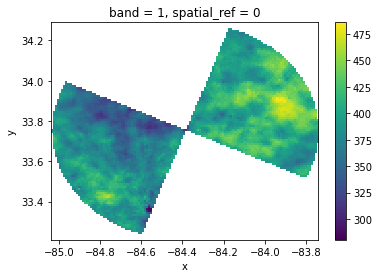

In [7]:
## Test mask for upwind and downwind regions at Atlanta
os.chdir('/glade/scratch/USERNAME/MRMS_PrecipData/Precip_map/')

ras_atl = rxr.open_rasterio('Atlanta_PrecipMap60.tif')
ras_atl = ras_atl[0]

d1 = 'W'
d2 = 'SW'

# angle array
center_x = int(np.floor(ras_atl.x.size/2))
center_y = int(np.floor(ras_atl.y.size/2))
xmat = np.array([[x-ras_atl.x[center_x].values for x in ras_atl.x.values]]*len(ras_atl.y.values))
ymat = np.array([[y-ras_atl.y[center_y].values for y in ras_atl.y.values]]*len(ras_atl.x.values)).T
arr_ang = np.rad2deg(np.arctan2(ymat,xmat))
arr_ang = np.array(arr_ang<0)*360+arr_ang
    
ang_buffer = xr.DataArray(
            data = arr_ang,
            dims = ['y','x'], # control the x,y layout when plotting
            coords = dict(
            x = (['x'],ras_atl.x.values),
            y = (['y'],ras_atl.y.values),
            )
        )

ras_filt = ras_atl.where(((ang_buffer>=157.5)&(ang_buffer<=247.5))|((ang_buffer>=337.5)|(ang_buffer<=67.5)))
ras_filt = ras_filt/7

ras_filt.plot.imshow()

np.savetxt('ATL_W_SW.mat',ras_filt)

## All wind speed

In [11]:
## DEI for top2 directions with all wind speed
os.chdir('/glade/scratch/USERNAME/MRMS_PrecipData/Precip_map/')

ls_city = ['Atlanta','Austin','Charlotte','Cincinnati','Columbus','Dallas','Houston','Indianapolis','KC','Louisville',
           'Memphis','Miami','Minneapolis','Nashville','NYC','OKC','Omaha','Orlando','Phoenix','Pittsburgh',
           'Richmond','SanAntonio','StLouis','Tucson','Philadelphia','DC','Baltimore']

## read csv containing prevailing directions
dat_drct = pd.read_csv('../T2Drct_SumPrecip60.csv',sep = ' ')

ls_up = [] ## store mean annual precip at upwind region
ls_dn = []
for city in ls_city:
    
    ras_all = rxr.open_rasterio(city+'_PrecipMap60.tif')
    ras_all = ras_all[0]
    
    # first 2 directions
    drcts = dat_drct[dat_drct['City']==city]['Top 2 drct'].values[0]
    d1 = drcts.split('+')[0]
    d2 = drcts.split('+')[1]
    
    # angle array
    center_x = int(np.floor(ras_all.x.size/2))
    center_y = int(np.floor(ras_all.y.size/2))
    xmat = np.array([[x-ras_all.x[center_x].values for x in ras_all.x.values]]*len(ras_all.y.values))
    ymat = np.array([[y-ras_all.y[center_y].values for y in ras_all.y.values]]*len(ras_all.x.values)).T
    arr_ang = np.rad2deg(np.arctan2(ymat,xmat))
    arr_ang = np.array(arr_ang<0)*360+arr_ang
    
    ang_buffer = xr.DataArray(
             data = arr_ang,
             dims = ['y','x'], # control the x,y layout when plotting
             coords = dict(
               x = (['x'],ras_all.x.values),
               y = (['y'],ras_all.y.values),
               )
            )
    
    if d1 == 'E':
        ras_up1 = ras_all.where((ang_buffer>=drct2val(d1)[0])|(ang_buffer<=drct2val(d1)[1]))
        ras_dn1 = ras_all.where((ang_buffer>=drct2val(d1)[2])&(ang_buffer<=drct2val(d1)[3]))
    elif d1 == 'W':
        ras_up1 = ras_all.where((ang_buffer>=drct2val(d1)[0])&(ang_buffer<=drct2val(d1)[1]))
        ras_dn1 = ras_all.where((ang_buffer>=drct2val(d1)[2])|(ang_buffer<=drct2val(d1)[3]))
    else:
        ras_up1 = ras_all.where((ang_buffer>=drct2val(d1)[0])&(ang_buffer<=drct2val(d1)[1]))
        ras_dn1 = ras_all.where((ang_buffer>=drct2val(d1)[2])&(ang_buffer<=drct2val(d1)[3]))
        
    if d2 == 'E':
        ras_up2 = ras_all.where((ang_buffer>=drct2val(d2)[0])|(ang_buffer<=drct2val(d2)[1]))
        ras_dn2 = ras_all.where((ang_buffer>=drct2val(d2)[2])&(ang_buffer<=drct2val(d2)[3]))
    elif d2 == 'W':
        ras_up2 = ras_all.where((ang_buffer>=drct2val(d2)[0])&(ang_buffer<=drct2val(d2)[1]))
        ras_dn2 = ras_all.where((ang_buffer>=drct2val(d2)[2])|(ang_buffer<=drct2val(d2)[3]))
    else:
        ras_up2 = ras_all.where((ang_buffer>=drct2val(d2)[0])&(ang_buffer<=drct2val(d2)[1]))
        ras_dn2 = ras_all.where((ang_buffer>=drct2val(d2)[2])&(ang_buffer<=drct2val(d2)[3]))
        
    # calculate average precip (sum in 7 years) at upwind and downwind regions of the 2 directions altogether
    res_up = (ras_up1.sum().values+ras_up2.sum().values)/(ras_up1.count().values+ras_up2.count().values)
    res_dn = (ras_dn1.sum().values+ras_dn2.sum().values)/(ras_dn1.count().values+ras_dn2.count().values)

    ls_up.append(res_up)
    ls_dn.append(res_dn)

print(ls_up)
print(ls_dn)

[2624.0962113659025, 1377.9730799683293, 2281.3949553001275, 2724.097816056598, 2224.5963479809975, 1440.6440776699028, 3308.10225921522, 2666.9994056463597, 2802.030467571644, 3046.869069624153, 2278.9332901554403, 2242.547227533461, 2221.923064516129, 2787.550936210727, 2537.1654335602248, 1952.4906058282209, 2571.961127487104, 4879.8472818311875, 591.3071548821549, 2302.3813609467456, 2559.142342624491, 1558.9961647153816, 2344.560514372163, 1491.9101765316718, 2709.0385078219015, 2512.875, 2679.274014778325]
[2873.5885363357215, 1365.5092745259687, 2563.186400541272, 2601.444207965947, 2554.0533373971352, 1819.9689034369885, 3488.483697895171, 2720.0128597672992, 3056.1919975186106, 2816.838618524333, 2365.1265442404006, 3559.302299703264, 2379.73, 2823.266315095583, 2123.6481207457828, 2036.2959101844426, 2326.93679720822, 4218.998144023756, 687.3812903774226, 2415.5441616766466, 3091.5028553299494, 1369.9171416938111, 2858.5906947500785, 1647.46045392022, 2632.762147570486, 3021.

In [12]:
DEI = [(j-i)/(i+j)/2 for i,j in zip(ls_up,ls_dn)]
#DEI = [round(x,2) for x in DEI]
print(DEI)

[0.022690672202887084, -0.0022715300905695114, 0.02908315750558838, -0.011515598556671116, 0.03447176620042069, 0.05816771692393788, 0.01327000348544415, 0.004920487601383687, 0.021692717497631856, -0.01961476111477633, 0.009279946550922655, 0.11347718223200286, 0.01714676587645623, 0.003182725197166341, -0.04436106572342975, 0.010505112772994004, -0.0250081073381543, -0.03631499969927981, 0.03756745274872815, 0.01199285577816593, 0.04710617053944348, -0.03227801632226847, 0.049396044792693126, 0.02477411807954606, -0.007139573822772369, 0.04599019998420417, 0.029197521397648737]


In [21]:
DEIs = pd.DataFrame(
{
    'City': ls_city,
    'DEI_AllWind': DEI,
    'DEI_LowWind': DEI_lws,
    'DEI_MidWind1': DEI_m1ws,
    'DEI_MidWind2': DEI_m2ws,
    'DEI_HighWind': DEI_hws
}
)
print(DEIs)
DEIs.to_csv('../DEI_Wind.csv')

            City  DEI_AllWind  DEI_LowWind  DEI_MidWind1  DEI_MidWind2  \
0        Atlanta     0.022691     0.071790      0.039759      0.001987   
1         Austin    -0.002272    -0.006534      0.015519      0.076882   
2      Charlotte     0.029083     0.024989      0.048317      0.030539   
3     Cincinnati    -0.011516     0.039691     -0.033777     -0.026213   
4       Columbus     0.034472    -0.024877      0.048418      0.086842   
5         Dallas     0.058168     0.016324      0.042006      0.092180   
6        Houston     0.013270    -0.019254      0.029783     -0.010680   
7   Indianapolis     0.004920     0.051338      0.016937     -0.002543   
8             KC     0.021693    -0.065733      0.050220      0.008349   
9     Louisville    -0.019615     0.017101     -0.022869     -0.016580   
10       Memphis     0.009280     0.016100     -0.043763     -0.010331   
11         Miami     0.113477     0.273696      0.146110     -0.000420   
12   Minneapolis     0.017147     0.02

# Non-dominant directions

In [3]:
from scipy import stats
os.chdir('/glade/scratch/USERNAME/MRMS_PrecipData/')
T2Drct = pd.read_csv('T2Drct_SumPrecip60.csv',sep = ' ')['Top 2 drct'].to_list()
start_yr = 2015
end_yr = 2021
ls_city = ['Atlanta','Austin','Charlotte','Cincinnati','Columbus','Dallas','Houston','Indianapolis','KC','Louisville',
           'Memphis','Miami','Minneapolis','Nashville','NYC','OKC','Omaha','Orlando','Phoenix','Pittsburgh',
           'Richmond','SanAntonio','StLouis','Tucson','Philadelphia','DC','Baltimore']
ls_lon = [-84.3880,-97.7431,-80.8431,-84.5120,-82.9988,-96.7970,-95.3698,-86.1581,-94.5786,-85.7585,-90.0490,
       -80.1918,-93.2650,-86.7816,-74.0060,-97.5164,-95.9345,-81.3789,-112.0740,-79.9959,-77.4360,-98.4936,-90.1994,
          -110.9747,-75.1652,-77.0369,-76.6122]
ls_lat = [33.7490,30.2672,35.2271,39.1031,39.9612,32.7767,29.7604,39.7684,39.0997,38.2527,35.1495,
       25.7617,44.9778,36.1627,40.7128,35.4676,41.2565,28.5384,33.4484,40.4406,37.5407,29.4241,38.6270,32.2226,39.9526,
         38.9072,39.2904]
buf_dis = 60 # radius of the round buffer, in km

ls_ks = []
ls_u = []
ls_size = []
for drct,city in zip(T2Drct,ls_city):
    df_upwnd = pd.DataFrame()
    df_dnwnd = pd.DataFrame()
    dat_wind = pd.DataFrame()
    df_domain = pd.DataFrame()
    for year in range(start_yr,end_yr+1):
        os.chdir('/glade/scratch/USERNAME/MRMS_PrecipData/'+str(year))
        filename_upwind = 'Results/upwind_'+city+str(buf_dis)+'.txt'
        filename_downwind = 'Results/downwind_'+city+str(buf_dis)+'.txt'
        filename_wind = 'wind_drct_'+city+'.txt'
        dat_precip_up = pd.read_csv(filename_upwind,delimiter=' ')
        dat_precip_dn = pd.read_csv(filename_downwind,delimiter=' ')
        wind = pd.read_csv(filename_wind,delimiter = ' ',header = None)
        df_upwnd = pd.concat([df_upwnd,dat_precip_up],ignore_index=True)
        df_dnwnd = pd.concat([df_dnwnd,dat_precip_dn],ignore_index=True)
        dat_wind = pd.concat([dat_wind,wind],ignore_index=True)
        #open domain stats
        file_domain = 'Results/domain stat/'+city+str(year)+'_'+str(buf_dis)+'.txt'
        domain = pd.read_csv(file_domain,sep=' ')
        df_domain = pd.concat([df_domain,domain],ignore_index=True)
    #print(df_domain)    
    dat_wind.columns = ['time','direction','speed']
    dat_wind['zone'] = pd.cut(x=dat_wind['direction'],bins=[0]+list(np.arange(22.5,338,45))+[360],right=False,
      labels=['E','NE','N','NW','W','SW','S','SE','E'],ordered=False)
    zone_count = dat_wind['zone'].value_counts()
    
    colnames = ["time","mean","median","min","max","std","sum","percentile(25)","percentile(75)","percentile(10)",
            "percentile(20)","percentile(30)","percentile(40)","xgrids(90)","xgrids(95)"]
    df_upwnd.columns = colnames
    df_upwnd['region'] = 'upwind'
    df_dnwnd.columns = colnames
    df_dnwnd['region'] = 'downwind'

    no_dup_up = pd.concat([dat_wind.time,df_upwnd.time]).drop_duplicates(keep=False)
    dat_wind = dat_wind.drop(no_dup_up.index.values)
    df_upwnd = dat_wind.merge(df_upwnd,how='outer',on='time')
    df_dnwnd = dat_wind.merge(df_dnwnd,how='outer',on='time')

    # filter
    #df_upwnd = df_upwnd[0.1<=df_upwnd['mean']]
    #df_dnwnd = df_dnwnd[0.1<=df_dnwnd['mean']]
    
    # in case there are NANs
    df_upwnd = df_upwnd[0<df_upwnd['mean']]
    df_dnwnd = df_dnwnd[0<df_dnwnd['mean']]

    intersect = set(df_upwnd['time'])&set(df_dnwnd['time'])
    df_upwnd = df_upwnd[df_upwnd['time'].isin(intersect)]
    df_dnwnd = df_dnwnd[df_dnwnd['time'].isin(intersect)]
    df_domain = df_domain[df_domain['time'].isin(intersect)]
    df_upwnd = df_upwnd.merge(df_domain,how='outer',on='time')
    df_dnwnd = df_dnwnd.merge(df_domain,how='outer',on='time')
    
    df_upwnd['norm_mean'] = (df_upwnd['mean']-df_upwnd['domain_avg'])/df_upwnd['domain_std']
    df_dnwnd['norm_mean'] = (df_dnwnd['mean']-df_dnwnd['domain_avg'])/df_dnwnd['domain_std']
    
    df_upwnd = df_upwnd[(df_upwnd['zone'] != drct.split('+')[0])&(df_upwnd['zone'] != drct.split('+')[1])]
    df_dnwnd = df_dnwnd[(df_dnwnd['zone'] != drct.split('+')[0])&(df_dnwnd['zone'] != drct.split('+')[1])]
    
    #print(df_dnwnd['norm_mean'].isnull().values.any())
    ks_mean = stats.ks_2samp(df_upwnd['norm_mean'],df_dnwnd['norm_mean'])[1]
    ls_ks.append(round(ks_mean,2))
    u_mean = stats.mannwhitneyu(df_upwnd['norm_mean'],df_dnwnd['norm_mean'])[1]
    ls_u.append(round(u_mean,2))
    #sample size
    ls_size.append(df_upwnd.shape[0])
    
print(ls_ks)
print(ls_u)

res_p = pd.DataFrame(
    {
        'City':ls_city,
        'Longitude':ls_lon,
        'Latitude':ls_lat,
        'KS-P':ls_ks,
        'U-P':ls_u,
        'Sample size':ls_size
    } 
)

os.chdir('/glade/scratch/USERNAME/MRMS_PrecipData/')
#res_p.to_csv('NonT2Drct_SigLevel'+str(buf_dis)+'.csv',sep=' ')

[0.08, 0.0, 0.0, 0.02, 0.6, 0.56, 0.33, 0.94, 0.79, 0.01, 0.27, 0.37, 0.0, 0.0, 0.01, 0.67, 0.51, 0.0, 0.02, 0.0, 0.15, 0.0, 0.64, 0.61, 0.0, 0.03, 0.0]
[0.02, 0.0, 0.0, 0.01, 0.79, 0.28, 0.82, 0.75, 0.42, 0.03, 0.17, 0.72, 0.0, 0.0, 0.01, 0.97, 0.49, 0.0, 0.01, 0.0, 0.14, 0.0, 0.53, 0.66, 0.0, 0.01, 0.0]


### DEI at non-dominant directions conditional on wind speed

In [7]:
## follow the above cell ## 
os.chdir('/glade/scratch/USERNAME/MRMS_PrecipData')
T2Drct = pd.read_csv('T2Drct_SumPrecip60.csv',sep = ' ')['Top 2 drct'].to_list()
start_yr = 2015
end_yr = 2021
ls_city = ['Atlanta','Austin','Charlotte','Cincinnati','Columbus','Dallas','Houston','Indianapolis','KC','Louisville',
           'Memphis','Miami','Minneapolis','Nashville','NYC','OKC','Omaha','Orlando','Phoenix','Pittsburgh',
           'Richmond','SanAntonio','StLouis','Tucson','Philadelphia','DC','Baltimore']
ls_lon = [-84.3880,-97.7431,-80.8431,-84.5120,-82.9988,-96.7970,-95.3698,-86.1581,-94.5786,-85.7585,-90.0490,
       -80.1918,-93.2650,-86.7816,-74.0060,-97.5164,-95.9345,-81.3789,-112.0740,-79.9959,-77.4360,-98.4936,-90.1994,
          -110.9747,-75.1652,-77.0369,-76.6122]
ls_lat = [33.7490,30.2672,35.2271,39.1031,39.9612,32.7767,29.7604,39.7684,39.0997,38.2527,35.1495,
       25.7617,44.9778,36.1627,40.7128,35.4676,41.2565,28.5384,33.4484,40.4406,37.5407,29.4241,38.6270,32.2226,39.9526,
         38.9072,39.2904]
buf_dis = 60 # radius of the round buffer, in km

ls_up_l = []
ls_dn_l = []
ls_up_m1 = []
ls_dn_m1 = []
ls_up_m2 = []
ls_dn_m2 = []
ls_up_h = []
ls_dn_h = []
for drct,city in zip(T2Drct,ls_city):
    df_upwnd = pd.DataFrame()
    df_dnwnd = pd.DataFrame()
    dat_wind = pd.DataFrame()
    df_domain = pd.DataFrame()
    for year in range(start_yr,end_yr+1):
        os.chdir('/glade/scratch/USERNAME/MRMS_PrecipData/'+str(year))
        filename_upwind = 'Results/upwind_'+city+str(buf_dis)+'.txt'
        filename_downwind = 'Results/downwind_'+city+str(buf_dis)+'.txt'
        filename_wind = 'wind_drct_'+city+'.txt'
        dat_precip_up = pd.read_csv(filename_upwind,delimiter=' ')
        dat_precip_dn = pd.read_csv(filename_downwind,delimiter=' ')
        wind = pd.read_csv(filename_wind,delimiter = ' ',header = None)
        df_upwnd = pd.concat([df_upwnd,dat_precip_up],ignore_index=True)
        df_dnwnd = pd.concat([df_dnwnd,dat_precip_dn],ignore_index=True)
        dat_wind = pd.concat([dat_wind,wind],ignore_index=True)
        #open domain stats
        file_domain = 'Results/domain stat/'+city+str(year)+'_'+str(buf_dis)+'.txt'
        domain = pd.read_csv(file_domain,sep=' ')
        df_domain = pd.concat([df_domain,domain],ignore_index=True)
    #print(df_domain)    
    dat_wind.columns = ['time','direction','speed']
    dat_wind['zone'] = pd.cut(x=dat_wind['direction'],bins=[0]+list(np.arange(22.5,338,45))+[360],right=False,
      labels=['E','NE','N','NW','W','SW','S','SE','E'],ordered=False)
    zone_count = dat_wind['zone'].value_counts()
    wnd_q1 = dat_wind['speed'].quantile(0.25) # get quartiles
    wnd_q2 = dat_wind['speed'].quantile(0.5)
    wnd_q3 = dat_wind['speed'].quantile(0.75)
    
    colnames = ["time","mean","median","min","max","std","sum","percentile(25)","percentile(75)","percentile(10)",
            "percentile(20)","percentile(30)","percentile(40)","xgrids(90)","xgrids(95)"]
    df_upwnd.columns = colnames
    df_upwnd['region'] = 'upwind'
    df_dnwnd.columns = colnames
    df_dnwnd['region'] = 'downwind'

    no_dup_up = pd.concat([dat_wind.time,df_upwnd.time]).drop_duplicates(keep=False)
    dat_wind = dat_wind.drop(no_dup_up.index.values)
    df_upwnd = dat_wind.merge(df_upwnd,how='outer',on='time')
    df_dnwnd = dat_wind.merge(df_dnwnd,how='outer',on='time')

    # filter
    #df_upwnd = df_upwnd[0.1<=df_upwnd['mean']]
    #df_dnwnd = df_dnwnd[0.1<=df_dnwnd['mean']]
    
    # in case there are NANs
    df_upwnd = df_upwnd[0<df_upwnd['mean']]
    df_dnwnd = df_dnwnd[0<df_dnwnd['mean']]
    
    # pick the common hours
    intersect = set(df_upwnd['time'])&set(df_dnwnd['time'])
    df_upwnd = df_upwnd[df_upwnd['time'].isin(intersect)]
    df_dnwnd = df_dnwnd[df_dnwnd['time'].isin(intersect)]
    df_domain = df_domain[df_domain['time'].isin(intersect)]
    df_upwnd = df_upwnd.merge(df_domain,how='outer',on='time')
    df_dnwnd = df_dnwnd.merge(df_domain,how='outer',on='time')
    
    df_upwnd = df_upwnd[(df_upwnd['zone'] != drct.split('+')[0])&(df_upwnd['zone'] != drct.split('+')[1])]
    df_dnwnd = df_dnwnd[(df_dnwnd['zone'] != drct.split('+')[0])&(df_dnwnd['zone'] != drct.split('+')[1])]
    
    df_upwnd_l = df_upwnd[df_upwnd['speed'] <= wnd_q1]
    df_dnwnd_l = df_dnwnd[df_dnwnd['speed'] <= wnd_q1]
    df_upwnd_m1 = df_upwnd[(wnd_q1<df_upwnd['speed'])&(df_upwnd['speed']<=wnd_q2)]
    df_dnwnd_m1 = df_dnwnd[(wnd_q1<df_dnwnd['speed'])&(df_dnwnd['speed']<=wnd_q2)]
    df_upwnd_m2 = df_upwnd[(wnd_q2<df_upwnd['speed'])&(df_upwnd['speed']<wnd_q3)]
    df_dnwnd_m2 = df_dnwnd[(wnd_q2<df_dnwnd['speed'])&(df_dnwnd['speed']<wnd_q3)]
    df_upwnd_h = df_upwnd[df_upwnd['speed'] >= wnd_q3]
    df_dnwnd_h = df_dnwnd[df_dnwnd['speed'] >= wnd_q3]
    
    ls_up_l.append(df_upwnd_l['mean'].sum())
    ls_dn_l.append(df_dnwnd_l['mean'].sum())
    ls_up_m1.append(df_upwnd_m1['mean'].sum())
    ls_dn_m1.append(df_dnwnd_m1['mean'].sum())
    ls_up_m2.append(df_upwnd_m2['mean'].sum())
    ls_dn_m2.append(df_dnwnd_m2['mean'].sum())
    ls_up_h.append(df_upwnd_h['mean'].sum())
    ls_dn_h.append(df_dnwnd_h['mean'].sum())
    
DEI_NonT2_LowWind = [(j-i)/(i+j)/2 for i,j in zip(ls_up_l,ls_dn_l)]
DEI_NonT2_MidWind1 = [(j-i)/(i+j)/2 for i,j in zip(ls_up_m1,ls_dn_m1)]
DEI_NonT2_MidWind2 = [(j-i)/(i+j)/2 for i,j in zip(ls_up_m2,ls_dn_m2)]
DEI_NonT2_HighWind = [(j-i)/(i+j)/2 for i,j in zip(ls_up_h,ls_dn_h)]
    
#DEI_NonT2_LowWind = [round(x,2) for x in DEI_NonT2_LowWind]
#DEI_NonT2_MidWind1 = [round(x,2) for x in DEI_NonT2_MidWind1]
#DEI_NonT2_MidWind2 = [round(x,2) for x in DEI_NonT2_MidWind2]
#DEI_NonT2_HighWind = [round(x,2) for x in DEI_NonT2_HighWind]

urb_size = []
## read in city size
dat = pd.read_csv('../DEI_Wnd.csv',sep = ' ')
for city in ls_city:
    urb_size.append(dat[dat['City']==city]['CitySize'].values.item())

DEIs = pd.DataFrame(
{
    'City': ls_city,
    'CitySize':urb_size,
    'DEI_LowWind_NonT2': DEI_NonT2_LowWind,
    'DEI_MidWind1_NonT2': DEI_NonT2_MidWind1,
    'DEI_MidWind2_NonT2': DEI_NonT2_MidWind2,
    'DEI_HighWind_NonT2': DEI_NonT2_HighWind
}
)
print(DEIs)
os.chdir('/glade/scratch/USERNAME/MRMS_PrecipData/')
DEIs.to_csv('./DEI_Wnd_NonT2.csv',sep = ' ')

            City  CitySize  DEI_LowWind_NonT2  DEI_MidWind1_NonT2  \
0        Atlanta     22.69           0.006028            0.025299   
1         Austin     15.38          -0.009200            0.011945   
2      Charlotte      8.82           0.082811           -0.012852   
3     Cincinnati     13.11           0.005154            0.005153   
4       Columbus     14.87          -0.021785           -0.021812   
5         Dallas     26.72           0.015939           -0.023914   
6        Houston     26.22           0.025081            0.061675   
7   Indianapolis     14.37           0.002640           -0.060994   
8             KC     15.88          -0.020757           -0.037921   
9     Louisville      9.58           0.064253            0.089511   
10       Memphis      7.06          -0.032219           -0.027463   
11         Miami     12.86          -0.064748           -0.083714   
12   Minneapolis     19.66           0.102013            0.080258   
13     Nashville      8.57        

## Local vs. synoptic effect

In [22]:
## local UHI-induced circulation effect can be represented by urban size
## synoptic effect is related to wind speed
## Hypothesis: the two effects are competing

os.chdir('/glade/scratch/USERNAME/MRMS_PrecipData/')

start_yr = 2015
end_yr = 2021

wind_sum = pd.read_csv('/glade/scratch/USERNAME/MRMS_PrecipData/T2Drct_SumPrecip60.csv',sep=' ')

df_urban = pd.read_csv('/glade/scratch/USERNAME/Modis/df_urban2.csv',sep = ' ')
df_urban = df_urban.sort_values('FullSize05')

urb_size = (df_urban['FullSize05']/2).tolist()
urb_size = [round(x,2) for x in urb_size]

cities = df_urban['City'].tolist()

## read DEI values
df_DEI = pd.read_csv('./DEI_Wind.csv')
DEI_AllWind = []
DEI_LowWind = []
DEI_MidWind1 = []
DEI_MidWind2 = []
DEI_HighWind = []

for city in cities:  ## use a for-loop since the sequence is changed due to sorting
    DEI_AllWind.append(df_DEI[df_DEI['City']==city]['DEI_AllWind'].values.item())
    DEI_LowWind.append(df_DEI[df_DEI['City']==city]['DEI_LowWind'].values.item())
    DEI_MidWind1.append(df_DEI[df_DEI['City']==city]['DEI_MidWind1'].values.item())
    DEI_MidWind2.append(df_DEI[df_DEI['City']==city]['DEI_MidWind2'].values.item())
    DEI_HighWind.append(df_DEI[df_DEI['City']==city]['DEI_HighWind'].values.item())

## get mean wind speed value at each group:
meanWS_low = [] # low is defined as smaller than q1 at t2 directions
meanWS_mid1 = []
meanWS_mid2 = []
meanWS_high = []

for city in cities:
    wind = pd.DataFrame()
    for year in range(start_yr,end_yr+1):
        tmp = pd.read_csv(str(year)+'/wind_drct_'+city+'.txt',sep=' ',header=None)
        wind = pd.concat([wind,tmp],ignore_index=True)
        
    wind.columns = ['time','direction','speed']
    wind['zone'] = pd.cut(x=wind['direction'],bins=[0]+list(np.arange(22.5,338,45))+[360],right=False,
      labels=['E','NE','N','NW','W','SW','S','SE','E'],ordered=False)
    
    drcts = wind_sum[wind_sum['City'] == city]['Top 2 drct'].values[0].split('+')
    wind = wind[wind['zone'].isin(drcts)]
    
    wnd_q1 = wind['speed'].quantile(0.25)
    wnd_q2 = wind['speed'].quantile(0.5)
    wnd_q3 = wind['speed'].quantile(0.75)
    
    wind_low = wind[wind['speed']<=wnd_q1]
    wind_mid1 = wind[(wnd_q1<wind['speed'])&(wind['speed']<=wnd_q2)]
    wind_mid2 = wind[(wnd_q2<wind['speed'])&(wind['speed']<wnd_q3)]
    wind_high = wind[wind['speed']>=wnd_q3]
    meanWS_low.append(wind_low['speed'].mean())
    meanWS_mid1.append(wind_mid1['speed'].mean())
    meanWS_mid2.append(wind_mid2['speed'].mean())
    meanWS_high.append(wind_high['speed'].mean())
    
# put components for plotting into a dataframe
df = pd.DataFrame(
   {
       'City':cities,
       'CitySize':urb_size,
       'DEI_AllWind':DEI_AllWind,
       'DEI_LowWind':DEI_LowWind,
       'DEI_MidWind1':DEI_MidWind1,
       'DEI_MidWind2':DEI_MidWind2,
       'DEI_HighWind':DEI_HighWind,
       'LowWind':meanWS_low,
       'MidWind1':meanWS_mid1,
       'MidWind2':meanWS_mid2,
       'HighWind':meanWS_high
   }
)

print(df)
df.to_csv('DEI_Wnd.csv',sep = ' ')

            City  CitySize  DEI_AllWind  DEI_LowWind  DEI_MidWind1  \
0       Richmond      5.55     0.047106     0.049886      0.058552   
1        Memphis      7.06     0.009280     0.016100     -0.043763   
2      Nashville      8.57     0.003183    -0.022266     -0.004587   
3      Charlotte      8.82     0.029083     0.024989      0.048317   
4          Omaha      9.33    -0.025008    -0.135477      0.007541   
5     Louisville      9.58    -0.019615     0.017101     -0.022869   
6            OKC      9.83     0.010505    -0.001939      0.035562   
7     Pittsburgh     10.59     0.011993    -0.029402      0.029096   
8         Tucson     11.85     0.024774    -0.007664      0.008488   
9          Miami     12.86     0.113477     0.273696      0.146110   
10    Cincinnati     13.11    -0.011516     0.039691     -0.033777   
11     Baltimore     13.87     0.029198     0.068309      0.085642   
12  Indianapolis     14.37     0.004920     0.051338      0.016937   
13    SanAntonio    

"\nplt.style.use(['science','no-latex'])\nplt.figure(figsize=(12,6))\nplt.scatter(df[df['DEI_LowWind']<0]['LowWind'],df[df['DEI_LowWind']<0]['CitySize'],\n            s = [-1500*x for x in df[df['DEI_LowWind']<0]['DEI_LowWind'].tolist()], ec='tab:blue',fc='none')\nplt.scatter(df[df['DEI_LowWind']>0]['LowWind'],df[df['DEI_LowWind']>0]['CitySize'],\n            s = [1500*x for x in df[df['DEI_LowWind']>0]['DEI_LowWind'].tolist()], c='tab:blue')\nplt.scatter(df[df['DEI_MidWind']<0]['MidWind'],df[df['DEI_MidWind']<0]['CitySize'],\n            s = [-1500*x for x in df[df['DEI_MidWind']<0]['DEI_MidWind'].tolist()], ec='tab:orange',fc='none')\nplt.scatter(df[df['DEI_MidWind']>0]['MidWind'],df[df['DEI_MidWind']>0]['CitySize'],\n            s = [1500*x for x in df[df['DEI_MidWind']>0]['DEI_MidWind'].tolist()], c='tab:orange')\nplt.scatter(df[df['DEI_HighWind']<0]['HighWind'],df[df['DEI_HighWind']<0]['CitySize'],\n            s = [-1500*x for x in df[df['DEI_HighWind']<0]['DEI_HighWind'].tolist(

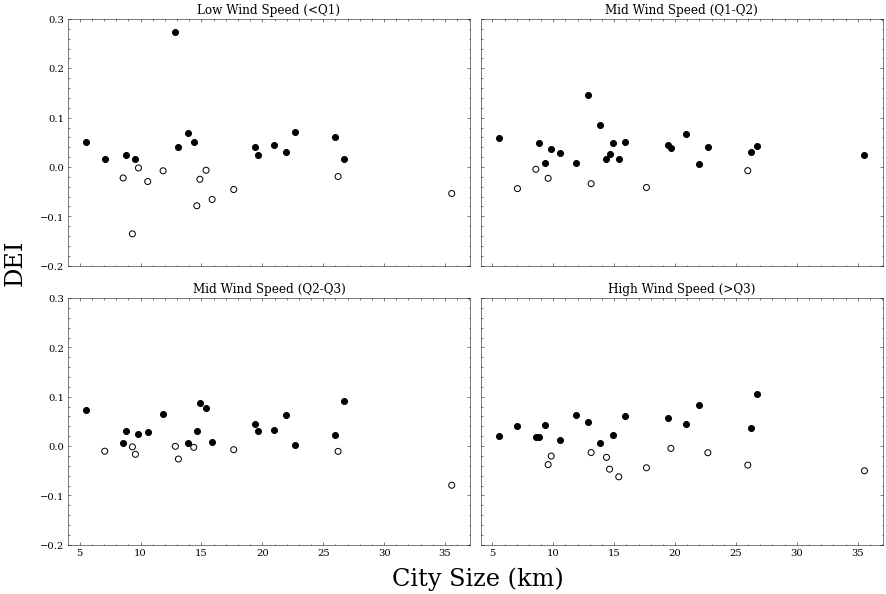

In [23]:
## DEI vs.city size at different speed groups (T2 direction)
os.chdir('/glade/scratch/USERNAME/MRMS_PrecipData/')
df = pd.read_csv('./DEI_Wnd.csv',sep = ' ')
#CitySize = df_DEI['CitySize'].tolist()
#DEI_LowWind = df_DEI['DEI_LowWind'].tolist()
#DEI_MidWind1 = df_DEI['DEI_MidWind1'].tolist()
#DEI_MidWind2 = df_DEI['DEI_MidWind2'].tolist()
#DEI_HighWind = df_DEI['DEI_HighWind'].tolist()

plt.style.use(['science','no-latex'])
fig,ax = plt.subplots(2,2,figsize=(12,8),sharey=True,sharex=True)

ax[0,0].scatter(df[df['DEI_LowWind']<0]['CitySize'],df[df['DEI_LowWind']<0]['DEI_LowWind'],ec='k',fc='none')
ax[0,0].scatter(df[df['DEI_LowWind']>0]['CitySize'],df[df['DEI_LowWind']>0]['DEI_LowWind'],c='k')
ax[0,1].scatter(df[df['DEI_MidWind1']<0]['CitySize'],df[df['DEI_MidWind1']<0]['DEI_MidWind1'],ec='k',fc='none')
ax[0,1].scatter(df[df['DEI_MidWind1']>0]['CitySize'],df[df['DEI_MidWind1']>0]['DEI_MidWind1'],c='k')
ax[1,0].scatter(df[df['DEI_MidWind2']<0]['CitySize'],df[df['DEI_MidWind2']<0]['DEI_MidWind2'],ec='k',fc='none')
ax[1,0].scatter(df[df['DEI_MidWind2']>0]['CitySize'],df[df['DEI_MidWind2']>0]['DEI_MidWind2'],c='k')
ax[1,1].scatter(df[df['DEI_HighWind']<0]['CitySize'],df[df['DEI_HighWind']<0]['DEI_HighWind'],ec='k',fc='none')
ax[1,1].scatter(df[df['DEI_HighWind']>0]['CitySize'],df[df['DEI_HighWind']>0]['DEI_HighWind'],c='k')

ax[0,0].set_ylim(-0.2,0.3)
ax[0,1].set_ylim(-0.2,0.3)
ax[1,0].set_ylim(-0.2,0.3)
ax[1,1].set_ylim(-0.2,0.3)

ax[0,0].set_title('Low Wind Speed (<Q1)')
ax[0,1].set_title('Mid Wind Speed (Q1-Q2)')
ax[1,0].set_title('Mid Wind Speed (Q2-Q3)')
ax[1,1].set_title('High Wind Speed (>Q3)')

fig.text(-0.03,0.5,'DEI',size=24,rotation=90)
fig.text(0.42,-0.03,'City Size (km)',size=24)

plt.tight_layout()

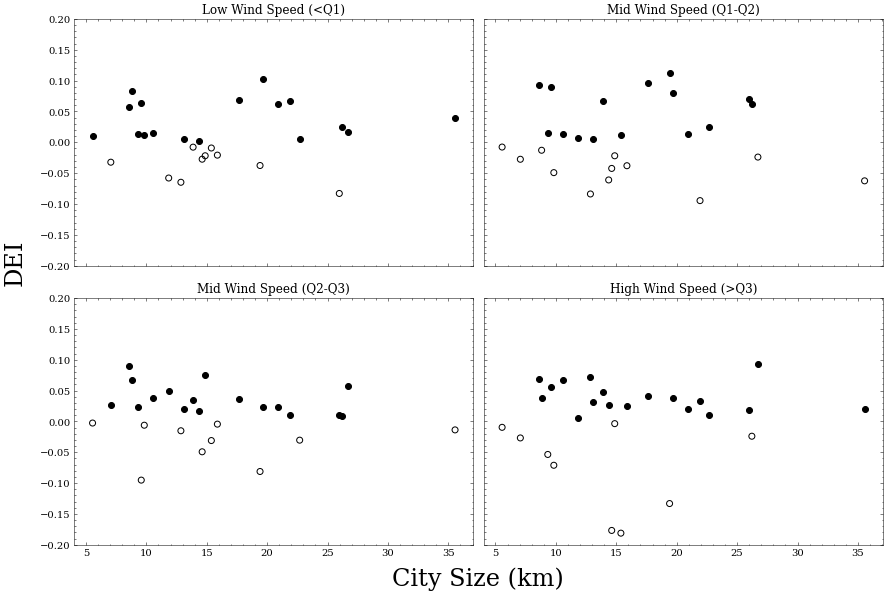

In [10]:
## DEI vs.city size at different speed groups (Non-T2 direction)
os.chdir('/glade/scratch/USERNAME/MRMS_PrecipData/')
df = pd.read_csv('./DEI_Wnd_NonT2.csv',sep = ' ')
#CitySize = df_DEI['CitySize'].tolist()
#DEI_LowWind = df_DEI['DEI_LowWind'].tolist()
#DEI_MidWind1 = df_DEI['DEI_MidWind1'].tolist()
#DEI_MidWind2 = df_DEI['DEI_MidWind2'].tolist()
#DEI_HighWind = df_DEI['DEI_HighWind'].tolist()

plt.style.use(['science','no-latex'])
fig,ax = plt.subplots(2,2,figsize=(12,8),sharey=True,sharex=True) 

ax[0,0].scatter(df[df['DEI_LowWind_NonT2']<0]['CitySize'],df[df['DEI_LowWind_NonT2']<0]['DEI_LowWind_NonT2'],ec='k',fc='none')
ax[0,0].scatter(df[df['DEI_LowWind_NonT2']>0]['CitySize'],df[df['DEI_LowWind_NonT2']>0]['DEI_LowWind_NonT2'],c='k')
ax[0,1].scatter(df[df['DEI_MidWind1_NonT2']<0]['CitySize'],df[df['DEI_MidWind1_NonT2']<0]['DEI_MidWind1_NonT2'],ec='k',fc='none')
ax[0,1].scatter(df[df['DEI_MidWind1_NonT2']>0]['CitySize'],df[df['DEI_MidWind1_NonT2']>0]['DEI_MidWind1_NonT2'],c='k')
ax[1,0].scatter(df[df['DEI_MidWind2_NonT2']<0]['CitySize'],df[df['DEI_MidWind2_NonT2']<0]['DEI_MidWind2_NonT2'],ec='k',fc='none')
ax[1,0].scatter(df[df['DEI_MidWind2_NonT2']>0]['CitySize'],df[df['DEI_MidWind2_NonT2']>0]['DEI_MidWind2_NonT2'],c='k')
ax[1,1].scatter(df[df['DEI_HighWind_NonT2']<0]['CitySize'],df[df['DEI_HighWind_NonT2']<0]['DEI_HighWind_NonT2'],ec='k',fc='none')
ax[1,1].scatter(df[df['DEI_HighWind_NonT2']>0]['CitySize'],df[df['DEI_HighWind_NonT2']>0]['DEI_HighWind_NonT2'],c='k')

ax[0,0].set_ylim(-0.2,0.2)
ax[0,1].set_ylim(-0.2,0.2)
ax[1,0].set_ylim(-0.2,0.2)
ax[1,1].set_ylim(-0.2,0.2)

ax[0,0].set_title('Low Wind Speed (<Q1)')
ax[0,1].set_title('Mid Wind Speed (Q1-Q2)')
ax[1,0].set_title('Mid Wind Speed (Q2-Q3)')
ax[1,1].set_title('High Wind Speed (>Q3)')

fig.text(-0.03,0.5,'DEI',size=24,rotation=90)
fig.text(0.42,-0.03,'City Size (km)',size=24)

plt.tight_layout()

Text(0.42, 0.04, 'City Size (km)')

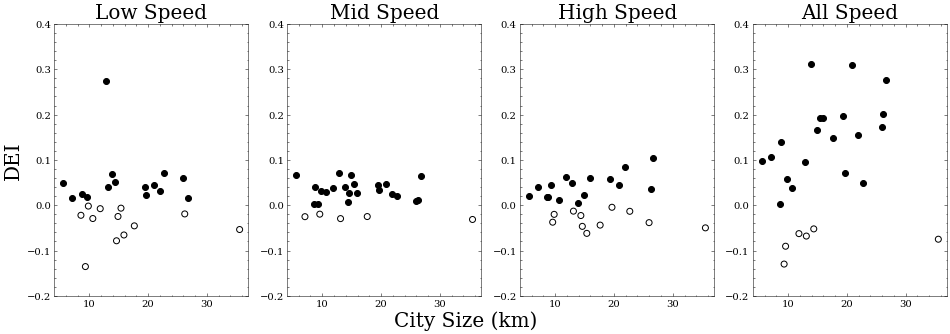

In [15]:
plt.style.use(['science','no-latex'])


fig,ax = plt.subplots(1,4,figsize=(16,5))
ax[0].scatter(df[df['DEI_LowWind']<0]['CitySize'],df[df['DEI_LowWind']<0]['DEI_LowWind'],ec='k',fc='none')
ax[0].scatter(df[df['DEI_LowWind']>0]['CitySize'],df[df['DEI_LowWind']>0]['DEI_LowWind'],c='k')#,c='tab:blue')
ax[0].set_ylabel('DEI',size=20)
ax[0].set_title('Low Speed',size=20)
ax[0].set_ylim(-0.2,0.4)

ax[1].scatter(df[df['DEI_MidWind']<0]['CitySize'],df[df['DEI_MidWind']<0]['DEI_MidWind'],ec='k',fc='none')
ax[1].scatter(df[df['DEI_MidWind']>0]['CitySize'],df[df['DEI_MidWind']>0]['DEI_MidWind'],c='k')
ax[1].set_title('Mid Speed',size=20)
ax[1].set_ylim(-0.2,0.4)

ax[2].scatter(df[df['DEI_HighWind']<0]['CitySize'],df[df['DEI_HighWind']<0]['DEI_HighWind'],ec='k',fc='none')
ax[2].scatter(df[df['DEI_HighWind']>0]['CitySize'],df[df['DEI_HighWind']>0]['DEI_HighWind'],c='k')
ax[2].set_title('High Speed',size=20)
ax[2].set_ylim(-0.2,0.4)

ax[3].scatter(df[df['DEI_AllWind']<0]['CitySize'],df[df['DEI_AllWind']<0]['DEI_AllWind'],ec='k',fc='none')
ax[3].scatter(df[df['DEI_AllWind']>0]['CitySize'],df[df['DEI_AllWind']>0]['DEI_AllWind'],c='k')
ax[3].set_title('All Speed',size=20)
ax[3].set_ylim(-0.2,0.4)

fig.text(0.42,0.04,'City Size (km)',size = 20)